In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
plt.rcParams["font.family"] = "serif"

### Problem 1        
Integrating using importance sampling: the integral is given as     
$$
    I=\int_0^\pi \frac{dy}{y^2 + \cos^2(y)}
$$
The weight function is given as:        
$$
    w(y) = ae^{-y}
$$

### Solution
For solving we first need to map the *Uniform Random Variables* in (0,1) to the given weight function.
\begin{align*}
    y(x) &= \int_0^x dt \times ae^{-t} = a(1-e^{-x})\\
    \implies x_i &= -\ln\left(1 - \frac{y_i}{a}\right)
\end{align*}
Thus the estimator of the integral is given by:         
$$
    \hat{I} = \frac{1}{N} \sum_{i=1}^N \frac{1}{(x_i)^2 + \cos^2(x_i)}\frac{1}{ae^{-x_i}}
$$

In [8]:
# defining the function to be integrated
def f(x):
    val = np.zeros(len(x))
    a = x[np.where(x<=np.pi)[0]]
    # getting non-zero values
    val_nz = np.power(np.power(a,2) + np.power(np.cos(a),2),-1)
    val[np.where(x<=np.pi)[0]] = val_nz
    return val
    
# defining the weight function
def w(x,a):
    return a*np.exp(-1*x)

# defining function to generate ramdom variables from the weight functions
def r(N,a):
    y = np.random.uniform(0,1,N)
    return np.log(1/(-y/a + 1))

In [6]:
# integrating by imporatance sampling
def imp_sampling(f,w,r,N,a):
    """
    Paramters
    ========================
    f: function to be integrated
    w: weigth function
    r: random variable generator
    N: Number of points
    a: parameter of the weight function
    """
    y_i = r(N,a)
    y = f(y_i)
    w_x = w(y_i,a)

    # estimator of integral
    I = np.sum(y/w_x)/N

    # calulating variance from the estimator
    F = y/w_x
    var = np.sum(F**2)/N - I**2
    return np.array([I,var])


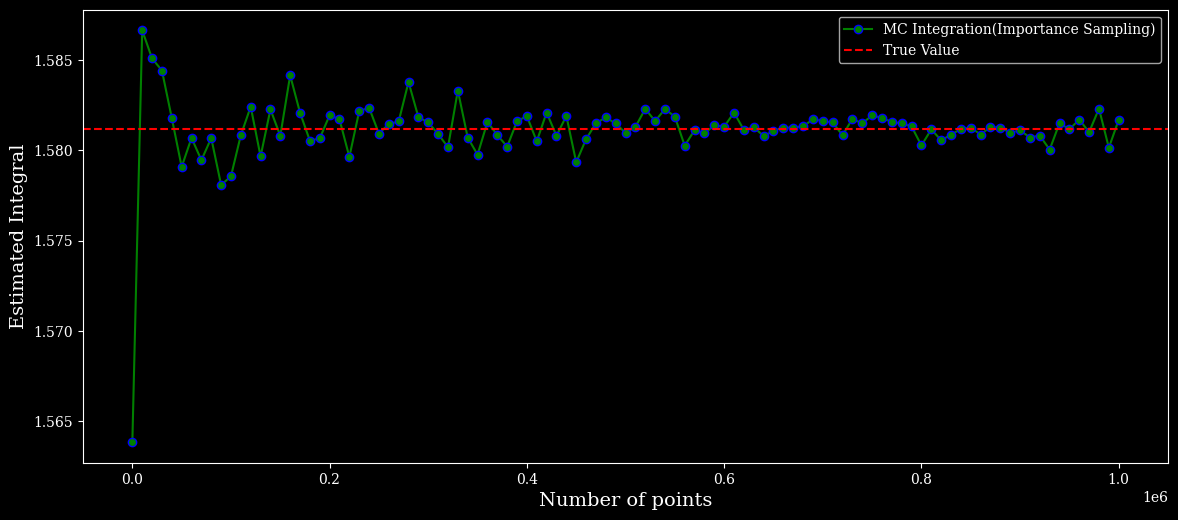

In [48]:
# calulating the integral using the imporance sampling for differnt N
N = np.linspace(100,1000000, 101)
val = []
for i in range(len(N)):
    val.append(imp_sampling(f,w,r,int(N[i]),1)[0])

exact_val = 1.58119

# plotting the results
plt.figure(figsize=(14,6), dpi=100)
plt.plot(N,val,c='green',marker='o',mec='blue', label = 'MC Integration(Importance Sampling)')
plt.axhline(exact_val,ls='--',color='red', label='True Value')
plt.xlabel('Number of points', fontsize=14)
plt.ylabel('Estimated Integral', fontsize=14)
plt.legend()

plt.savefig('WS5_1_a.jpg', bbox_inches='tight', dpi=300)


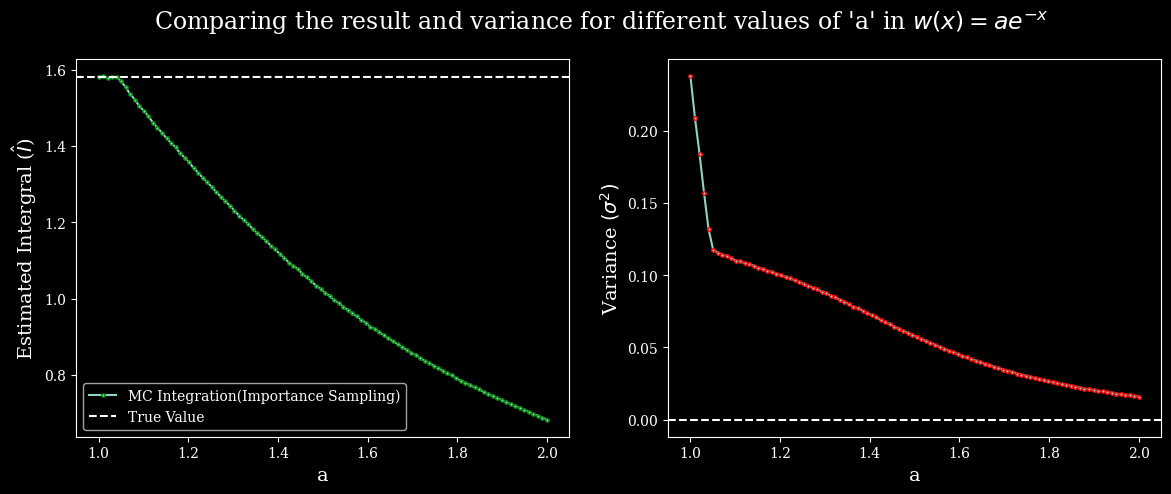

In [12]:
# calulating the integral using the imporance sampling method for differnt a
A = np.linspace(1,2, 100)
val = []
var = []
for i in range(len(A)):
    results = imp_sampling(f,w,r,100000,A[i])
    val.append(results[0])
    var.append(results[1])

# plotting the results
fig, ax = plt.subplots(1,2, figsize=(14,5), dpi=100)

# plotting values in subplot 1
ax[0].plot(A,val,marker='o',ms=2.5,mec='green', label = 'MC Integration(Importance Sampling)')
ax[0].axhline(exact_val,ls='--', label='True Value')
ax[0].set_xlabel('a', fontsize=14)
ax[0].set_ylabel('Estimated Intergral ($\\hat{I}$)', fontsize=14)
ax[0].legend(loc='best')

#plotting variance in subplot 2
ax[1].plot(A,var,marker='o',ms=2.5,mec='red', label = 'MC Integration(Importance Sampling)')
ax[1].axhline(0,ls='--', label='No Variance($\\sigma^2=0$)')
ax[1].set_xlabel('a', fontsize=14)
ax[1].set_ylabel('Variance $(\\sigma^2)$', fontsize=14)

plt.suptitle("Comparing the result and variance for different values of 'a' in $w(x) = ae^{-x}$", fontsize=17);
#plt.savefig('WS5_1_b.jpg', bbox_inches='tight', dpi=300)

### Problem 2: *Metropolis Hastings's Algorithm*

We want to sample the distribution:     
$$
    P(x) = \mathcal{N}(\mu, \sigma)
$$

We can use the Metropolis-Hastings algorithm to sample from this distribution. We define a *Markov Chain* for a possible value of $x$ and, and the stationary distribution of the Markov Chain follows the distribution of $P(x)$.  
##### Algorithm
- We start by assigning a value to the initial state of the Markov Chain: $x_0$. 
- In the consecutive steps we assume that we know $x_n$ and we want $x_{n+1}$
- Now we need to generate a candidate $x^*$ from our proposal distribution $Q(x^*|x_n)$ which depends the current state of Markov Chain. For our case we again sample it from a Normal Distribution:
    $$
        x^*|x_n \sim \mathcal{N}(\mu_n, \sigma_n) \equiv \mathcal{N}(x_n, \sigma_n=1)
    $$
- Next step is to calculate the acceptance probability:
    $$
        A_n(x_n \rightarrow x^*) = min\left( 1, \frac{P(x^*)Q(x_n|x^*)}{P(x_n)Q(x^*|x_n)}\right)
    $$
    where $Q(x^*|x_n)$ is the probability of the proposal distribution given the current state of the Markov Chain.     
    For our case, since we are sampling from a Normal Distribution $\mathcal{N}(x_n,\sigma_n)$, $Q(x^*|x_n)$, and $Q(x_n|x^*)$ are equal(due to symmetry), thus the acceptance probability reduces to     
    $$
        A_n(x_n \rightarrow x^*) = min\left( 1, \frac{P(x^*)}{P(x_n)}\right)
    $$
- Now that we have $x^*$ and $A_n(x_n \rightarrow x^*)$ we can decide whether to accept the candidate or not. For that we generate a random normal $u$ from a uniform Distribution i.e $ u \sim Uniform(0,1)$. Then we accept and reject based on:
    $$
        x_{n+1}= 
        \begin{cases}
            x^* & \text{if } u \leq A_n(x_n \rightarrow x^*) \\
            x_n & \text{otherwise}
        \end{cases}
    $$

In [3]:
# defining the target distribution
mu = 3 #mean of proposed/target distribution
sigma = 1 #standard deviation of propsed/target destribution
def targetdist(x):
    """
    Returns the PDF of a general normal distribution.
    It is our target distribution.
    """
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-1*(x-mu)**2/(2*sigma**2))

# defining the Metropolis Hasting steping
def MHstep(x0,sigma_p, targetdist):
    """
    Returns the new value of x after a Metropolis Hasting step
    
    Parameters
    ========================
    x0: current value of x (Current State)
    sigma_p: standard deviation of the sampling distribution
    targetdist: target distribution

    Returns
    ========================
    x1: new value of x (Next State)
    a: 1 if the new value of x is accepted, 0 otherwise
    """

    # generating a candidate value of x from a normal distribution centered around x0 and with supplied standard deviation
    x = np.random.normal(loc=x0,scale=sigma_p) 
    # Computing acceptance probability
    A = targetdist(x)/targetdist(x0)

    # Acceptance and Rejection Step
    u = np.random.uniform(0,1)
    if u <= A:
        x1 = x #accepting
        a = 1  #storing acceptance
    else:
        x1 = x0 #rejecting
        a = 0   #storing rejection

    return x1, a

In [4]:
# Running the Metropolis Hasting algorithm

## Parameters
nsamples = 1000000 #number of samples in the chain
x0 = 3 #starting value of the chain
burnin = 1 #number of burn-in steps
sigma1 = 1 #standard deviation for MH Candidate generation

# Storing the chain
X_MC = np.zeros(nsamples)
X_MC[0] = x0
acceptance = 0

# running the chain
for i in tqdm(range(nsamples), "Number of Samples: "):
    # doing burin steps
    for j in range(burnin):
        x, a = MHstep(X_MC[i-1],sigma1,targetdist)
    if a == 1:
        X_MC[i] = x
        acceptance = acceptance + 1
    else:
        X_MC[i] = X_MC[i-1]

Number of Samples: 100%|██████████| 1000000/1000000 [00:13<00:00, 71806.96it/s]


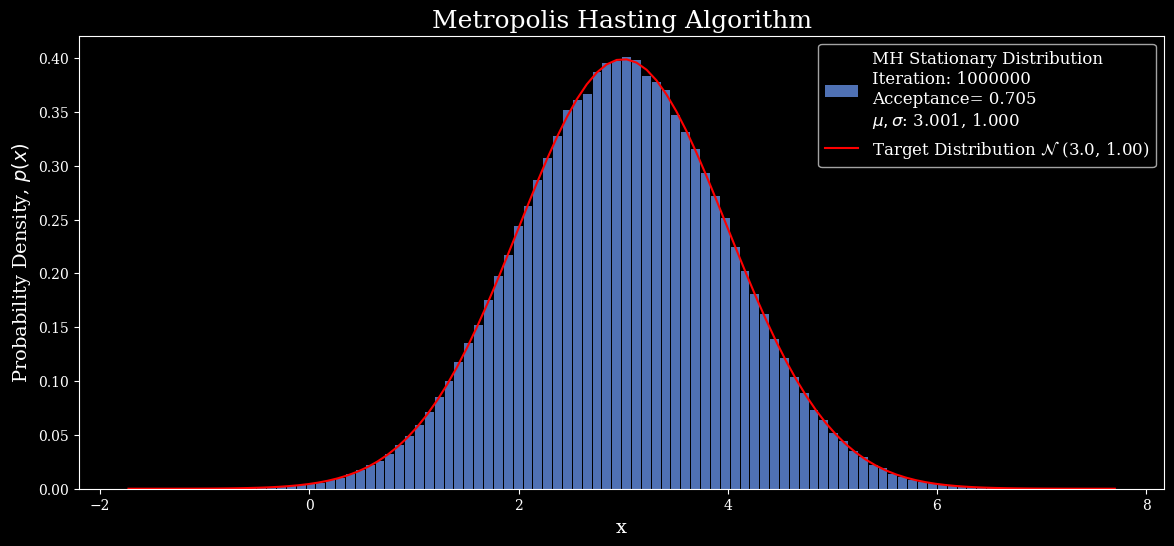

In [6]:
# mean and variance of the chain
mean_MC = np.mean(X_MC)
var_MC = np.var(X_MC)

# plotting the results
plt.figure(figsize=(14,6), dpi=100)

bins= plt.hist(X_MC, bins=100, density=True, color='#4f71b4', rwidth=0.9,
                 label='MH Stationary Distribution\nIteration: %2d\nAcceptance= %2.3f \n$\\mu,\\sigma$: %2.3f, %2.3f' 
                 %(nsamples,acceptance/nsamples,mean_MC,np.sqrt(var_MC))
            )
# plotting the target distribution
x = np.linspace(min(bins[1]),max(bins[1]),100)
plt.plot(x,targetdist(x),c='red',label='Target Distribution $\\mathcal{N}$ (%2.1f, %2.2f)'%(mu,sigma))
plt.legend(loc='best', fontsize=12)

plt.title('Metropolis Hasting Algorithm', fontsize=18);
plt.ylabel('Probability Density, $p(x)$', fontsize=14);
plt.xlabel('x', fontsize=14);

#plt.savefig('WS5_2_a.jpg', bbox_inches='tight', dpi=300)

In [16]:
# Running metropolis hasting for different values of samples

N = [1000, 10000, 100000, 1000000]
MC = [] #master markov chain array
A = [] #acceptance array

for nsamples in tqdm(N):
    MC.append(np.zeros(nsamples))
    MC[-1][0] = x0
    acceptance = 0
    for i in range(nsamples):
        for j in range(burnin):
            x, a = MHstep(MC[-1][i-1],sigma1,targetdist)
        if a == 1:
            MC[-1][i] = x
            acceptance = acceptance + 1
        else:
            MC[-1][i] = MC[-1][i-1]
    mean_MC = np.mean(MC[-1])
    var_MC = np.var(MC[-1])
    A.append(acceptance/nsamples)
    print('\n\nIteration: %2d\nAcceptance= %2.3f \nmu,sigma : %2.3f, %2.3f' 
                 %(nsamples,acceptance/nsamples,mean_MC,np.sqrt(var_MC)))

 50%|█████     | 2/4 [00:00<00:00, 10.44it/s]



Iteration: 1000
Acceptance= 0.698 
mu,sigma : 2.985, 1.122


Iteration: 10000
Acceptance= 0.706 
mu,sigma : 2.979, 1.031


Iteration: 100000
Acceptance= 0.704 
mu,sigma : 3.004, 1.007


100%|██████████| 4/4 [00:14<00:00,  3.51s/it]



Iteration: 1000000
Acceptance= 0.704 
mu,sigma : 2.996, 1.001
[0.698, 0.7056, 0.7044, 0.704347]


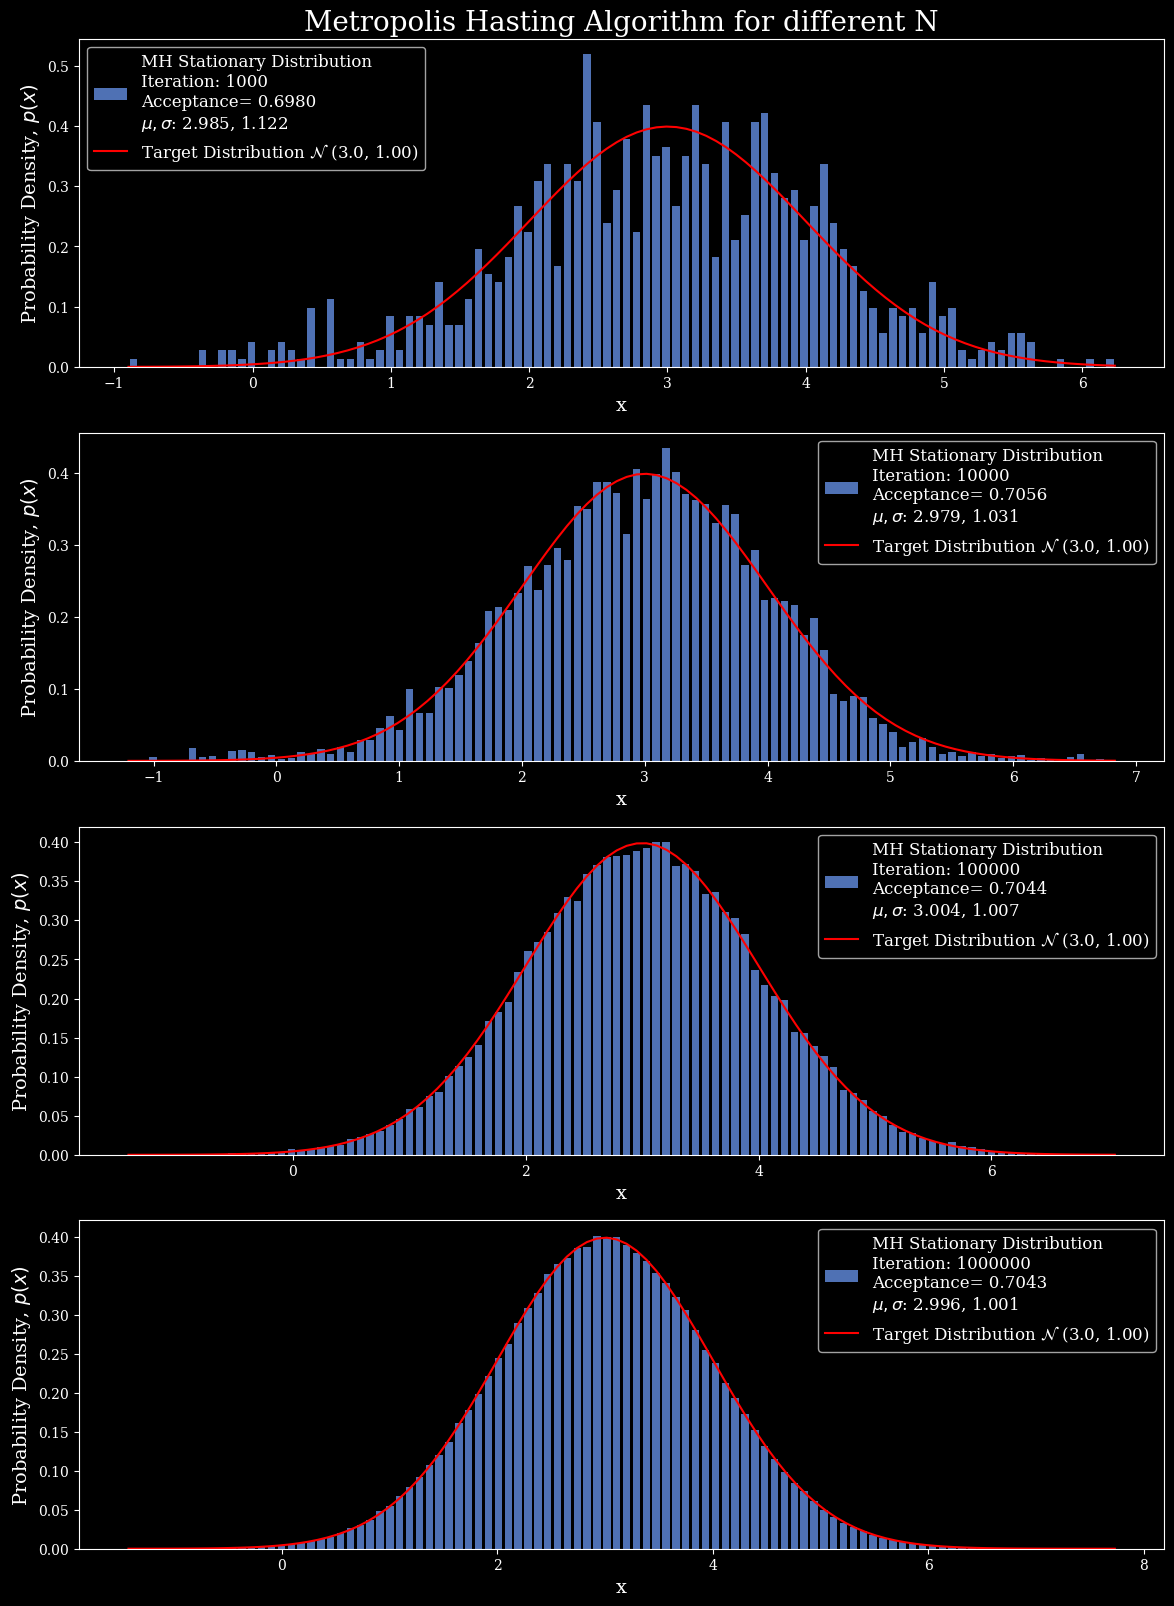

In [17]:
# plotting the distributions in 4 subplots
fig, ax = plt.subplots(4,1, figsize=(14,20), dpi=100)

# ploting histograms and distribution in subplots
for i in range(4):
    mean_MC = np.mean(MC[i])
    var_MC = np.var(MC[i])
    bins = ax[i].hist(MC[i], bins=100, density=True, color='#4f71b4', rwidth=0.75,
                    label='MH Stationary Distribution\nIteration: %2d\nAcceptance= %2.4f \n$\\mu,\\sigma$: %2.3f, %2.3f'
                    %(N[i], A[i], mean_MC, np.sqrt(var_MC))
                )
    # plotting the target distribution
    x = np.linspace(min(bins[1]),max(bins[1]),100)
    ax[i].plot(x,targetdist(x),c='red',label='Target Distribution $\\mathcal{N}$ (%2.1f, %2.2f)'%(mu,sigma))
    ax[i].legend(loc='best', fontsize=12)
    ax[i].set_ylabel('Probability Density, $p(x)$', fontsize=14);
    ax[i].set_xlabel('x', fontsize=14);

ax[0].set_title("Metropolis Hasting Algorithm for different N", fontsize=20);
# plt.savefig('WS6_2_b.jpg', bbox_inches='tight', dpi=300)